# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [10]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-4,3e-4,5e-4,7e-4,1e-5,3e-5,6e-5,8e-5,1e-3,5e-3,1e-6,5e-6]
regularization_strengths = [5e4, 5e5, 5e6,1e4,3e4,1e5,1e6,3e5]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for curr_reg in regularization_strengths:
        curr_svm = LinearSVM()
        loss_hist = curr_svm.train(X_train_feats,y_train,lr,curr_reg,num_iters = 1000,batch_size = 200,verbose = True)
        train_acc = np.mean((curr_svm.predict(X_train_feats) == y_train).astype(int))
        val_acc = np.mean((curr_svm.predict(X_val_feats) == y_val).astype(int))
        results[(lr,curr_reg)] = (train_acc,val_acc)
        print("Current best:",best_val)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = curr_svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 8.995008
iteration 100 / 1000: loss 8.353936
iteration 200 / 1000: loss 7.565750
iteration 300 / 1000: loss 6.739191
iteration 400 / 1000: loss 6.465936
iteration 500 / 1000: loss 5.808041
iteration 600 / 1000: loss 5.597339
iteration 700 / 1000: loss 5.433303
iteration 800 / 1000: loss 5.158160
iteration 900 / 1000: loss 4.844870
Current best: -1
iteration 0 / 1000: loss 8.998489
iteration 100 / 1000: loss 8.189540
iteration 200 / 1000: loss 7.486602
iteration 300 / 1000: loss 6.926827
iteration 400 / 1000: loss 6.099088
iteration 500 / 1000: loss 5.916504
iteration 600 / 1000: loss 5.531742
iteration 700 / 1000: loss 5.092725
iteration 800 / 1000: loss 5.000063
iteration 900 / 1000: loss 4.838206
Current best: 0.433
iteration 0 / 1000: loss 8.994299
iteration 100 / 1000: loss 8.316103
iteration 200 / 1000: loss 7.580918
iteration 300 / 1000: loss 6.739535
iteration 400 / 1000: loss 6.558500
iteration 500 / 1000: loss 5.860893
iteration 600 / 1000: loss 5.7718

Current best: 0.478
iteration 0 / 1000: loss 9.009582
iteration 100 / 1000: loss 5.808990
iteration 200 / 1000: loss 4.816331
iteration 300 / 1000: loss 4.693471
iteration 400 / 1000: loss 4.364382
iteration 500 / 1000: loss 4.418997
iteration 600 / 1000: loss 3.507770
iteration 700 / 1000: loss 3.877415
iteration 800 / 1000: loss 3.858885
iteration 900 / 1000: loss 3.707785
Current best: 0.478
iteration 0 / 1000: loss 8.991164
iteration 100 / 1000: loss 5.703133
iteration 200 / 1000: loss 4.509495
iteration 300 / 1000: loss 4.221990
iteration 400 / 1000: loss 4.418428
iteration 500 / 1000: loss 4.467368
iteration 600 / 1000: loss 3.730363
iteration 700 / 1000: loss 3.436122
iteration 800 / 1000: loss 3.934437
iteration 900 / 1000: loss 4.028811
Current best: 0.478
iteration 0 / 1000: loss 8.995357
iteration 100 / 1000: loss 5.497769
iteration 200 / 1000: loss 4.259905
iteration 300 / 1000: loss 3.697972
iteration 400 / 1000: loss 3.634662
iteration 500 / 1000: loss 3.915064
iteration 

iteration 200 / 1000: loss 8.564443
iteration 300 / 1000: loss 8.335198
iteration 400 / 1000: loss 8.126810
iteration 500 / 1000: loss 7.933144
iteration 600 / 1000: loss 7.957679
iteration 700 / 1000: loss 7.579337
iteration 800 / 1000: loss 7.177775
iteration 900 / 1000: loss 6.909314
Current best: 0.485
iteration 0 / 1000: loss 9.005855
iteration 100 / 1000: loss 8.784262
iteration 200 / 1000: loss 8.556734
iteration 300 / 1000: loss 8.400225
iteration 400 / 1000: loss 8.202157
iteration 500 / 1000: loss 7.940376
iteration 600 / 1000: loss 7.695714
iteration 700 / 1000: loss 7.657003
iteration 800 / 1000: loss 7.499377
iteration 900 / 1000: loss 6.979358
Current best: 0.485
iteration 0 / 1000: loss 9.011168
iteration 100 / 1000: loss 8.799622
iteration 200 / 1000: loss 8.574115
iteration 300 / 1000: loss 8.365339
iteration 400 / 1000: loss 8.185524
iteration 500 / 1000: loss 7.931424
iteration 600 / 1000: loss 7.662278
iteration 700 / 1000: loss 7.657886
iteration 800 / 1000: loss 7

iteration 400 / 1000: loss 3.875746
iteration 500 / 1000: loss 3.484414
iteration 600 / 1000: loss 3.020068
iteration 700 / 1000: loss 3.689662
iteration 800 / 1000: loss 3.681400
iteration 900 / 1000: loss 3.365836
Current best: 0.488
iteration 0 / 1000: loss 8.997459
iteration 100 / 1000: loss 4.647974
iteration 200 / 1000: loss 4.404585
iteration 300 / 1000: loss 4.003286
iteration 400 / 1000: loss 3.511771
iteration 500 / 1000: loss 3.321921
iteration 600 / 1000: loss 3.777991
iteration 700 / 1000: loss 3.284642
iteration 800 / 1000: loss 3.074610
iteration 900 / 1000: loss 3.263777
Current best: 0.488
iteration 0 / 1000: loss 8.988932
iteration 100 / 1000: loss 5.001237
iteration 200 / 1000: loss 4.408109
iteration 300 / 1000: loss 3.726028
iteration 400 / 1000: loss 3.866104
iteration 500 / 1000: loss 3.712394
iteration 600 / 1000: loss 3.403594
iteration 700 / 1000: loss 3.194600
iteration 800 / 1000: loss 2.838149
iteration 900 / 1000: loss 3.040785
Current best: 0.488
iteratio

iteration 500 / 1000: loss 8.810844
iteration 600 / 1000: loss 8.796164
iteration 700 / 1000: loss 8.762876
iteration 800 / 1000: loss 8.739514
iteration 900 / 1000: loss 8.659281
Current best: 0.495
iteration 0 / 1000: loss 8.979690
iteration 100 / 1000: loss 8.943830
iteration 200 / 1000: loss 8.903043
iteration 300 / 1000: loss 8.888235
iteration 400 / 1000: loss 8.852953
iteration 500 / 1000: loss 8.790311
iteration 600 / 1000: loss 8.766858
iteration 700 / 1000: loss 8.773762
iteration 800 / 1000: loss 8.718417
iteration 900 / 1000: loss 8.671357
Current best: 0.495
iteration 0 / 1000: loss 8.986557
iteration 100 / 1000: loss 8.963127
iteration 200 / 1000: loss 8.918635
iteration 300 / 1000: loss 8.889893
iteration 400 / 1000: loss 8.856935
iteration 500 / 1000: loss 8.831808
iteration 600 / 1000: loss 8.764590
iteration 700 / 1000: loss 8.751969
iteration 800 / 1000: loss 8.722368
iteration 900 / 1000: loss 8.681379
Current best: 0.495
iteration 0 / 1000: loss 9.007821
iteration 

In [11]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.49


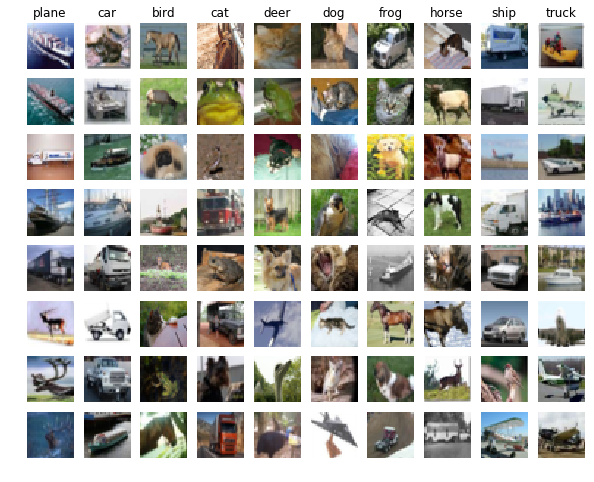

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
The results make sense,we can see that the images that were classified as planes actually have corners and edges which are quite similar to the ones that we have in the plane image, we know that the HOG algorithm helps extract from the image a list of features(defined as the histogram of the gradients) which represent the corners and edges of the image(these are the spots where the gradients are the largest because the change in the curve is much larger)

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
print(X_train_feats.shape)

(49000, 155)


In [49]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 100
num_classes = 10
print(X_train_feats.shape)
'''
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=1e4, verbose=True)
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

'''

learning_rates = [1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6,1e-7,
                  5e-7,1e-8,5e-8,1e-9,5e-9,1e-10,1e-11,1e-12,1e-13,1e-14]
regularizations = [1e6,5e6,1e5,5e5,1e4,5e4,1e3,5e3,1e2,5e2,1e1,5e1,1e-1
                   ,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6,1e-7,5e-7,1e-8,5e-8,1e-9,5e-9,1e-10
                  ,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18,1e-19,1e-20]

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
for lr in learning_rates:
    for curr_reg in regularizations:
        print("Current lr:%f reg:%f" % (lr,curr_reg))
        curr_net = TwoLayerNet(input_dim,hidden_dim,num_classes)
        loss_hist = curr_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=10000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=curr_reg, verbose=False)
        train_acc = np.mean((curr_net.predict(X_train_feats) == y_train).astype(int))
        val_acc = np.mean((curr_net.predict(X_val_feats) == y_val).astype(int))
        print("Training accuracy: ",train_acc)
        print("Current best:",best_val)
        if val_acc > best_val:
            best_val = val_acc
            best_net = curr_net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
print("Best validation accuracy:",best_val)

(49000, 155)
Current lr:0.100000 reg:1000000.000000
Training accuracy:  0.100265306122
Current best: -1
Current lr:0.100000 reg:5000000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:100000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:500000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:10000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:50000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:1000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:5000.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:100.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:500.000000
Training accuracy:  0.100265306122
Current best: 0.087
Current lr:0.100000 reg:10.000000
Training accuracy:  0.100448979592
C

Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.010000 reg:50.000000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.100000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.500000
Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.010000 reg:0.010000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.050000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.001000
Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.010000 reg:0.005000
Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.010000 reg:0.000100
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.000500
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.010000 reg:0.000010
Training accuracy:  0.118530612245
Current best: 0.6
Current lr:0.010000 reg:0.000050
Training accuracy:  0.100448979592
Current best: 0.6


Training accuracy:  0.100040816327
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100265306122
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.0998571428571
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100265306122
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100265306122
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100428571429
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100265306122
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100448979592
Current best: 0.6
Current lr:0.001000 reg:0.000000
Training accuracy:  0.100428571429
Current best: 0.6


KeyboardInterrupt: 

In [50]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.11


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!